## Figure 1 and Figure S1

This notebook contains the code to generate the plots in Figure 1 and Figure S1.

Author: Ruth Hanna

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import base_edit_functions_v3 as be
from colors import get_colors
from sklearn.metrics import auc, precision_recall_curve, roc_curve, roc_auc_score, average_precision_score
from scipy.stats import pearsonr
color_dict = get_colors()
sns.set(style='ticks',context='paper')

First, we import the 3 filtered datafiles for the tiling library screened with BE3, BE4, and WT-Cas9. To obtain these files from the provided supplementary data, run the Screening Data Preprocessing notebook.

In [2]:
be3 = pd.read_csv('../Data/Filtered_LFC_files/Table_S1_filtered_BE3_v1.csv')
be4 = pd.read_csv('../Data/Filtered_LFC_files/Table_S1_filtered_BE4_v1.csv')
wt = pd.read_csv('../Data/Filtered_LFC_files/Table_S1_filtered_WT-Cas9_v1.csv')

We also define the relevant gene sets: pan-lethal genes, control (cell surface) genes, and vemurafenib resistance genes.

In [3]:
panlethal_genes = ['EEF2','HNRNPU','KPNB1','PELP1','POLR1C','PSMA6','RPS20','SF3B1','SNRPD1','TFRC']
control_genes = ['ICAM1','FAS','CD81','CD33']
vem_genes = ['NF1','NF2','CUL3','MED12']


We then generate "ridgeplots" showing the depletion of sgRNAs in each mutation bin. This function can be found in the "base_edit_functions.py" file.

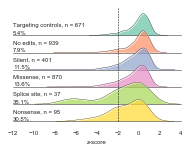

<Figure size 432x288 with 0 Axes>

In [4]:
# A375, BE3, pan-lethal genes
fig,ax=be.make_ridgeplots(data=be3,
                col='A375;Dropout;AvgAB;LFC_pdna;z-score', 
                cutoff=-2, 
                lims=[-12,4], 
                ticks=[-12,-10,-8,-6,-4,-2,0,2,4], 
                xlabel='z-score', 
                geneset=panlethal_genes, 
                control_geneset=control_genes)
fig.savefig('../Figures/Fig1_Benchmarking/A375_panlethal_BE3.pdf',transparent=True,bbox_inches='tight')

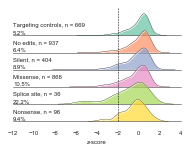

<Figure size 432x288 with 0 Axes>

In [5]:
# A375, BE4, pan-lethal genes
fig,ax=be.make_ridgeplots(data=be4,
                col='A375;Dropout;AvgAB;LFC_pdna;z-score', 
                cutoff=-2, 
                lims=[-12,4], 
                ticks=[-12,-10,-8,-6,-4,-2,0,2,4], 
                xlabel='z-score', 
                geneset=panlethal_genes, 
                control_geneset=control_genes)
fig.savefig('../Figures/Fig1_Benchmarking/A375_panlethal_BE4.pdf',transparent=True,bbox_inches='tight')

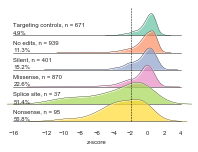

<Figure size 432x288 with 0 Axes>

In [6]:
# HAP1, BE3, pan-lethal genes
fig,ax=be.make_ridgeplots(data=be3,
                col='HAP1;Dropout;AvgAB;LFC_pdna;z-score', 
                cutoff=-2, 
                lims=[-16,4], 
                ticks=[-16,-12,-10,-8,-6,-4,-2,0,2,4], 
                xlabel='z-score', 
                geneset=panlethal_genes, 
                control_geneset=control_genes)
fig.savefig('../Figures/Fig1_Benchmarking/HAP1_panlethal_BE3.pdf',transparent=True,bbox_inches='tight')

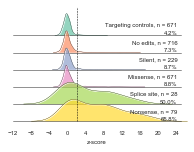

<Figure size 432x288 with 0 Axes>

In [7]:
# A375, BE3, vemurafenib resistance genes
fig,ax=be.make_ridgeplots(data=be3,
                col='A375;Vemurafenib;MinAB;LFC_dropout;z-score', 
                cutoff=2, 
                lims=[-12,25], 
                ticks=[-12,-8,-4,0,4,8,12,16,20,24], 
                xlabel='z-score', 
                geneset=vem_genes, 
                control_geneset=control_genes)
fig.savefig('../Figures/Fig1_Benchmarking/A375_vemurafenib_BE3.pdf',transparent=True,bbox_inches='tight')

Next, we generate receiver-operator characteristic (ROC) curves to compare sgRNAs predicted to introduce Nonsense / Splice site mutations (true positives) to sgRNAs predicted to introduce No edits / Silent edits (true negatives).

In [8]:
sns.set(style='ticks',context='paper')

In [12]:
# This function generates an ROC curve for a specified geneset
# True positives = sgRNAs predicted to make nonsense or splice site mutations
# True negatives = sgRNAs predicted to make silent mutations or no edits
def get_roc(input_data,col_list,label_list,title='',geneset=panlethal_genes,ascending_val=False):
    # Filter for sgRNAs in specified geneset
    df = input_data.loc[input_data['Gene symbol'].isin(geneset),:].copy()
    
    # Define true positives and true negatives
    df.loc[:,str('true_pos')] = np.nan
    df.loc[df['Mutation bin'].isin(['Nonsense','Splice site']),str('true_pos')] = 1
    df.loc[df['Mutation bin'].isin(['No edits','Silent']),str('true_pos')] = 0
    
    # Filter dataframe to include only true positives and true negatives
    data = df.loc[df[str('true_pos')].isin([0,1]),:]
    
    # Print set sizes
    print 'positive n = ' + str(len(data[data[str('true_pos')] == 1]))
    print 'negative n = ' + str(len(data[data[str('true_pos')] == 0]))  

    # Generate figure
    fig,ax = plt.subplots(figsize=(2,2))
    
    # Go through each column specified in col_list
    for i,colname in enumerate(col_list):    
        # Calculate percent rank for specified column
        data.loc[:,str(colname+'pctrank')] = data[colname].rank(ascending=ascending_val,pct=True)
        # Calculate fpr, tpr, roc_auc
        fpr, tpr, thresholds = roc_curve(data['true_pos'], data[str(colname + 'pctrank')])
        roc_auc = auc(fpr, tpr)
        print str(label_list[i] + ' = ' + str(roc_auc))
        plt.plot(fpr,tpr,color=sns.color_palette('Set2')[i],linewidth=1)

    # Tidy up plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    plt.xlabel('False positive rate\n(silent / no edits)',fontsize=8)
    plt.ylabel('True positive rate\n(nonsense and splice site)',fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)    
    plt.title(title,y=1.0,fontsize=8)    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5,length=4)
    return fig,ax

In [13]:
# This function generates an ROC curve for a specified geneset using two different input datasets
# True positives = sgRNAs predicted to make nonsense or splice site mutations
# True negatives = sgRNAs predicted to make silent mutations or no edits
def get_roc_2_datasets(data1,col1,data2,col2,label_list,title='',geneset=panlethal_genes,ascending_val=False):

    fig,ax = plt.subplots(figsize=(2,2))
    i = 0
    # Go through each dataset / col pair
    for input_data,colname in [(data1,col1),(data2,col2)]:
        # Filter to include only sgRNAs in specified geneset
        df = input_data.loc[input_data['Gene symbol'].isin(geneset),:].copy()

        # Define true positives, true negatives
        df.loc[:,str('true_pos')] = np.nan
        df.loc[df['Mutation bin'].isin(['Nonsense','Splice site']),str('true_pos')] = 1
        df.loc[df['Mutation bin'].isin(['No edits','Silent']),str('true_pos')] = 0
        data = df.loc[df[str('true_pos')].isin([0,1]),:]

        # Print set sizes
        print 'positive n = ' + str(len(data[data[str('true_pos')] == 1]))
        print 'negative n = ' + str(len(data[data[str('true_pos')] == 0]))  
    
        # Calculate percent rank based on specified column
        data.loc[:,str(colname+'pctrank')] = data[colname].rank(ascending=ascending_val,pct=True)
        # Calculate fpr, tpr, auc
        fpr, tpr, thresholds = roc_curve(data['true_pos'], data[str(colname + 'pctrank')])
        roc_auc = auc(fpr, tpr)
        print str(label_list[i] + ' = ' + str(roc_auc))
        plt.plot(fpr,tpr,color=sns.color_palette('Set2')[i+4],linewidth=1)
        i+=1

    # Tidy up plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    ax.set_xticks([0,0.5,1])
    ax.set_yticks([0,0.5,1])
    plt.xlabel('False positive rate\n(silent / no edits)',fontsize=8)
    plt.ylabel('True positive rate\n(nonsense and splice site)',fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)    
    plt.title(title,y=1.0,fontsize=8)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5,length=4)
    return fig,ax

positive n = 132
negative n = 1340
HAP1 = 0.8251243781094526


/Users/rhanna/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rhanna/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


MELJUSO = 0.8146031207598372
OVCAR8 = 0.7913048394391675
HA1E = 0.7403041610131164
A375 = 0.6882575757575757


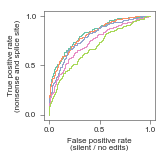

In [14]:
fig,ax = get_roc(be3,
                 ['HAP1;Dropout;AvgAB;LFC_pdna;z-score',
                  'MELJUSO;Dropout;AvgAB;LFC_pdna;z-score',
                  'OVCAR8;Dropout;AvgAB;LFC_pdna;z-score',
                  'HA1E;Dropout;AvgAB;LFC_pdna;z-score',
                  'A375;Dropout;AvgAB;LFC_pdna;z-score'],
                 ['HAP1','MELJUSO','OVCAR8','HA1E','A375'])
fig.savefig('../Figures/Fig1_Benchmarking/Panlethal_ROC_v2.pdf',transparent=True,bbox_inches='tight')

positive n = 107
negative n = 945
A375 = 0.8427829698857736


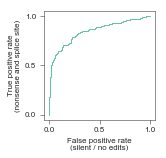

In [15]:
fig,ax = get_roc(input_data=be3,
                 col_list=['A375;Vemurafenib;MinAB;LFC_dropout;z-score'],
                 label_list=['A375'],
                 ascending_val=True,
                 geneset=vem_genes)
fig.savefig('../Figures/Fig1_Benchmarking/Vem_ROC_v1.pdf',transparent=True,bbox_inches='tight')

positive n = 33
negative n = 279
HAP1 = 0.9019224503095471
MELJUSO = 0.8697729988052569
OVCAR8 = 0.8685782556750299
HA1E = 0.8372977082654502
A375 = 0.7694145758661887


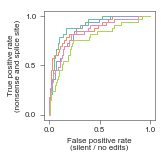

In [22]:
fig,ax = get_roc(be3.loc[be3['On-target efficacy score'] > 0.6,:],
                 ['HAP1;Dropout;AvgAB;LFC_pdna;z-score',
                  'MELJUSO;Dropout;AvgAB;LFC_pdna;z-score',
                  'OVCAR8;Dropout;AvgAB;LFC_pdna;z-score',
                  'HA1E;Dropout;AvgAB;LFC_pdna;z-score',
                  'A375;Dropout;AvgAB;LFC_pdna;z-score'],
                 ['HAP1','MELJUSO','OVCAR8','HA1E','A375'])
fig.savefig('../Figures/Fig1_Benchmarking/Panlethal_ROC_RS2_v1.pdf',transparent=True,bbox_inches='tight')

positive n = 132
negative n = 1340
BE3 = 0.6882575757575757
positive n = 132
negative n = 1341
BE4 = 0.6180428445529116


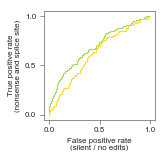

In [23]:
# Figure S1D
col = 'A375;Dropout;AvgAB;LFC_pdna;z-score'
fig,ax = get_roc_2_datasets(be3,col,be4,col,['BE3','BE4'])
fig.savefig('../Figures/Fig1_Benchmarking/Fig_S1D_BE3_BE4_ROC_v2.pdf',transparent=True,bbox_inches='tight')

Next, we generate a scatterplot to compare Rule Set 2 score and z-score for sgRNAs predicted to make nonsense or splice site mutations in pan-lethal genes. We use the HAP1 cell line data from the BE3 screen (the top-performing cell line).

Pearson r = -0.44


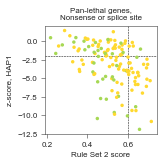

In [25]:
fig,ax=plt.subplots(figsize=(2,2))
col = 'HAP1;Dropout;AvgAB;LFC_pdna;z-score'
sns.scatterplot(x='On-target efficacy score',y=col,
                data=be3[(be3['Gene symbol'].isin(panlethal_genes)) & (be3['Mutation bin'].isin(['Nonsense','Splice site']))],
                hue='Mutation bin',s=12,legend=False,linewidth=0,hue_order=['Splice site','Nonsense'],
                palette=[sns.color_palette('Set2')[4],sns.color_palette('Set2')[5]],zorder=1)

# Tidy up plot
ax.set_xlabel('Rule Set 2 score',fontsize=8)
ax.set_ylabel('z-score, HAP1',fontsize=8)
ax.axhline(-2,linewidth=0.5,linestyle='dashed',color='black',zorder=0)
ax.axvline(0.6,linewidth=0.5,linestyle='dashed',color='black',zorder=0)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(width=0.5,length=4)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)  
plt.title('Pan-lethal genes,\nNonsense or splice site',fontsize=8)

# Calculate Pearson correlation
temp = be3[(be3['Gene symbol'].isin(panlethal_genes)) & (be3['Mutation bin'].isin(['Nonsense','Splice site']))]
print 'Pearson r = ' + str(np.round(pearsonr(temp['On-target efficacy score'],temp[col])[0],2))
fig.savefig('../Figures/Fig1_Benchmarking/HAP1_RS2.pdf',transparent=True,bbox_inches='tight')

Finally, we merge the BE3 and WT screening data and compare the two (just looking, again, at sgRNAs predicted to make nonsense or splice site mutations in pan-lethal genes, n = 132 sgRNAs).

In [26]:
merge = pd.merge(be3,wt,on=['Construct Barcode','Gene symbol','Mutation bin'],suffixes=['_BE3','_WT'])
merge = merge[(merge['Gene symbol'].isin(panlethal_genes)) & (merge['Mutation bin'].isin(['Nonsense','Splice site']))]
print 'Number of sgRNAs for comparison  = ' + str(len(merge))

Number of sgRNAs for comparison  = 132


In [27]:
def make_scatter(col):
    fig,ax=plt.subplots(figsize=(2,2))
    sns.scatterplot(x=col+'_WT',y=col+'_BE3',data=merge,hue='Mutation bin',s=12,legend=False,linewidth=0,hue_order=['Splice site','Nonsense'],
                   palette=[sns.color_palette('Set2')[4],sns.color_palette('Set2')[5]],zorder=1)
    ax.set_xlabel('z-score, WT-Cas9',fontsize=8)
    ax.set_ylabel('z-score, BE3.9max',fontsize=8)
    ax.axhline(-2,linewidth=0.5,linestyle='dashed',color='black',zorder=0)
    ax.axvline(-2,linewidth=0.5,linestyle='dashed',color='black',zorder=0)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5,length=4)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)  
    print 'Pearson r = ' + str(np.round(pearsonr(merge[col+'_WT'],merge[col+'_BE3'])[0],2))
    return fig,ax

Pearson r = 0.22


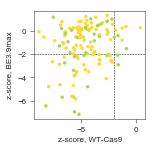

In [28]:
fig,ax = make_scatter(col = 'A375;Dropout;AvgAB;LFC_pdna;z-score')
fig.savefig('../Figures/Fig1_Benchmarking/A375_WT_BE3.pdf',transparent=True,bbox_inches='tight')

Pearson r = 0.28


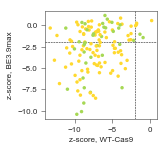

In [29]:
fig,ax = make_scatter(col = 'MELJUSO;Dropout;AvgAB;LFC_pdna;z-score')
fig.savefig('../Figures/Fig1_Benchmarking/A375_WT_BE3.pdf',transparent=True,bbox_inches='tight')